# Training a model

This notebook takes input TTrees that contain event-level branches and classifies between different groups of events.

## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
#Global parameters:
indir = '../../input_trees/ForTraining/'
chno = 0 #mumu 

In [3]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth):

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    
    #Exceptions
    if 'QCD' in filename or 'VLL' in filename:
        sample = filename.split("_")[1]+"_"+filename.split("_")[2]
        subsample = filename.split("_")[3].split(".")[0]
        
    if subsample.endswith(".root"): subsample = subsample[:-5]

    tfile = uproot.open(filepath)
    ttree = tfile['myEvents']
    branches = ttree.keys()
    awkarray = ttree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    df['sample'] = sample
    df['subsample'] = subsample

    #print(f'dataframe for {sample} {subsample} loaded.')
    return df

def prepare_df(jobname, samples, truth):
    print(f'\nPicking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    for s in samples:
        files = os.listdir(os.path.join(indir, jobname))
        for f in files:
            if s not in f: continue
            filepath = os.path.join(indir, jobname, f)
            df = read_file_into_df(filepath, truth)
            if df.empty:
                print(f"\033[0;31mWarning: Skipping empty file: {f}\033[0m")
                continue
            else:
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")
            '''
            if 'channel' in df.columns:
                df = df[df['channel'] == chno]  # Filtering by channel
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")
            else:
                print(f"\033[0;31mWarning: 'channel' column not found in {f}. Skipping this file.\033[0m")
            '''
    return dfout

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [4]:
%%time

bkgsamples = ['QCD_MuEnriched', 'QCD_EMEnriched']
sigsamples = ['VLLD_mu_M100', 'VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400'] #, 'VLLD_mu_M600', 'VLLD_mu_M800']
#sigsamples = ['VLLD_ele_M100', 'VLLD_ele_M200', 'VLLD_ele_M300', 'VLLD_ele_M400'] #, 'VLLD_ele_M600', 'VLLD_ele_M800', 'VLLD_ele_M1000']

bkgdf = prepare_df('tree_forTraining_Sept30_2LSSincl', bkgsamples, 0)
sigdf = prepare_df('tree_forTraining_Sept30_2LSSincl', sigsamples, 1)

print('\033[1;32mDone reading samples.\033[0m\n')

modelname = 'qcd-vs-vlld-mu-m400-sept30'
os.makedirs(modelname, exist_ok=True)

print('Ready to proceed.')


Picking files from ../../input_trees/ForTraining/tree_forTraining_Sept30_2LSSincl
dataframe for tree_QCD_MuEnriched_120to170.root loaded.
dataframe for tree_QCD_MuEnriched_170to300.root loaded.
dataframe for tree_QCD_MuEnriched_20to30.root loaded.
dataframe for tree_QCD_MuEnriched_300to470.root loaded.
dataframe for tree_QCD_MuEnriched_30to50.root loaded.
dataframe for tree_QCD_MuEnriched_470to600.root loaded.
dataframe for tree_QCD_MuEnriched_50to80.root loaded.
dataframe for tree_QCD_MuEnriched_600to800.root loaded.
dataframe for tree_QCD_MuEnriched_800to1000.root loaded.
dataframe for tree_QCD_MuEnriched_80to120.root loaded.
dataframe for tree_QCD_EMEnriched_120to170.root loaded.
dataframe for tree_QCD_EMEnriched_170to300.root loaded.
dataframe for tree_QCD_EMEnriched_300toInf.root loaded.
dataframe for tree_QCD_EMEnriched_30to50.root loaded.
dataframe for tree_QCD_EMEnriched_50to80.root loaded.
dataframe for tree_QCD_EMEnriched_80to120.root loaded.

Picking files from ../../input_

In [5]:
df = pd.concat([sigdf, bkgdf])
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]
print(df.keys())
print(f'Signal and background before filtering: {nsig}, {nbkg}')

Index(['channel', 'nlep', 'njet', 'nbjet', 'lep0_pt', 'lep0_eta', 'lep0_phi',
       'lep0_iso', 'lep0_sip3d', 'lep0_mt', 'lep1_pt', 'lep1_eta', 'lep1_phi',
       'lep1_iso', 'lep1_sip3d', 'lep1_mt', 'dilep_pt', 'dilep_eta',
       'dilep_phi', 'dilep_mass', 'dilep_mt', 'dilep_deta', 'dilep_dphi',
       'dilep_dR', 'dilep_ptratio', 'HT', 'LT', 'STvis', 'ST', 'HTMETllpt',
       'STfrac', 'metpt', 'metphi', 'dphi_metlep0', 'dphi_metlep1',
       'dphi_metdilep', 'dphi_metlep_max', 'dphi_metlep_min', 'jec', 'jer',
       'wt_leptonSF', 'wt_trig', 'wt_bjet', 'weight', 'truth', 'sample',
       'subsample'],
      dtype='object')
Signal and background before filtering: 13944, 333492


### Filtering the dataframe

In [6]:
df = df.query('lep0_iso < 1.0 and lep1_iso < 1.0')
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]
print(f'Signal and background after filtering: {nsig}, {nbkg}')

Signal and background after filtering: 11455, 14955


In [7]:
df

,channel,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,lep0_mt,...,dphi_metlep_min,jec,jer,wt_leptonSF,wt_trig,wt_bjet,weight,truth,sample,subsample
0,0,2,1,0,33.108379,0.696167,2.029297,0.000000,0.596680,52.223152,...,1.284439,1.0,0.984047,0.955288,0.950463,0.941926,0.907966,1,VLLD_mu,M100
1,3,2,0,0,38.133701,-0.713379,2.573242,0.018245,1.656250,94.277931,...,2.724304,1.0,1.000000,0.937047,0.997546,1.000000,0.934748,1,VLLD_mu,M100
2,0,2,0,0,28.225590,1.917725,-2.783203,0.000000,0.286621,116.076790,...,2.013672,1.0,1.000000,0.995077,0.953162,1.000000,0.948469,1,VLLD_mu,M100
3,2,2,1,0,51.070248,-0.374756,-1.160156,0.000000,0.851562,119.937904,...,1.934082,1.0,1.027383,0.980158,0.950463,1.294408,0.931604,1,VLLD_mu,M100
4,2,2,0,0,59.053986,-1.369873,-1.732666,0.000000,1.613281,90.380859,...,0.794739,1.0,1.000000,0.953049,0.997546,1.000000,0.950710,1,VLLD_mu,M100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333468,3,2,1,0,50.849915,-1.467285,2.067871,0.000000,0.677246,16.016289,...,0.337402,1.0,1.033640,0.970703,0.950463,1.000000,0.922617,0,QCD_EMEnriched,80to120
333469,0,2,2,0,39.053360,-1.192139,-1.709961,0.282344,0.964355,4.680603,...,0.083252,1.0,0.997912,0.972323,0.997680,1.000000,0.970067,0,QCD_EMEnriched,80to120
333470,2,2,5,0,47.320690,-2.398926,0.540771,0.008439,0.970215,246.194580,...,0.025391,1.0,1.013460,0.995098,0.953162,1.000000,0.948490,0,QCD_EMEnriched,80to120
333487,1,2,2,1,38.723217,0.134857,-2.480957,0.156688,2.562500,24.011583,...,0.686994,1.0,1.007004,0.991934,0.950463,0.961531,0.942796,0,QCD_EMEnriched,80to120


### Exploring the variables

In [8]:
import matplotlib.pyplot as plt
import math
os.makedirs('plots', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def plot_in_group(listvar, figname, suptitle=None, alias=None):
    num_vars = len(listvar)
    ncols = 4
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * 2.5
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins':'auto',
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        ax[i].hist(sigdata, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)
    
    
    plt.tight_layout()
    plt.savefig(f'plots/{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


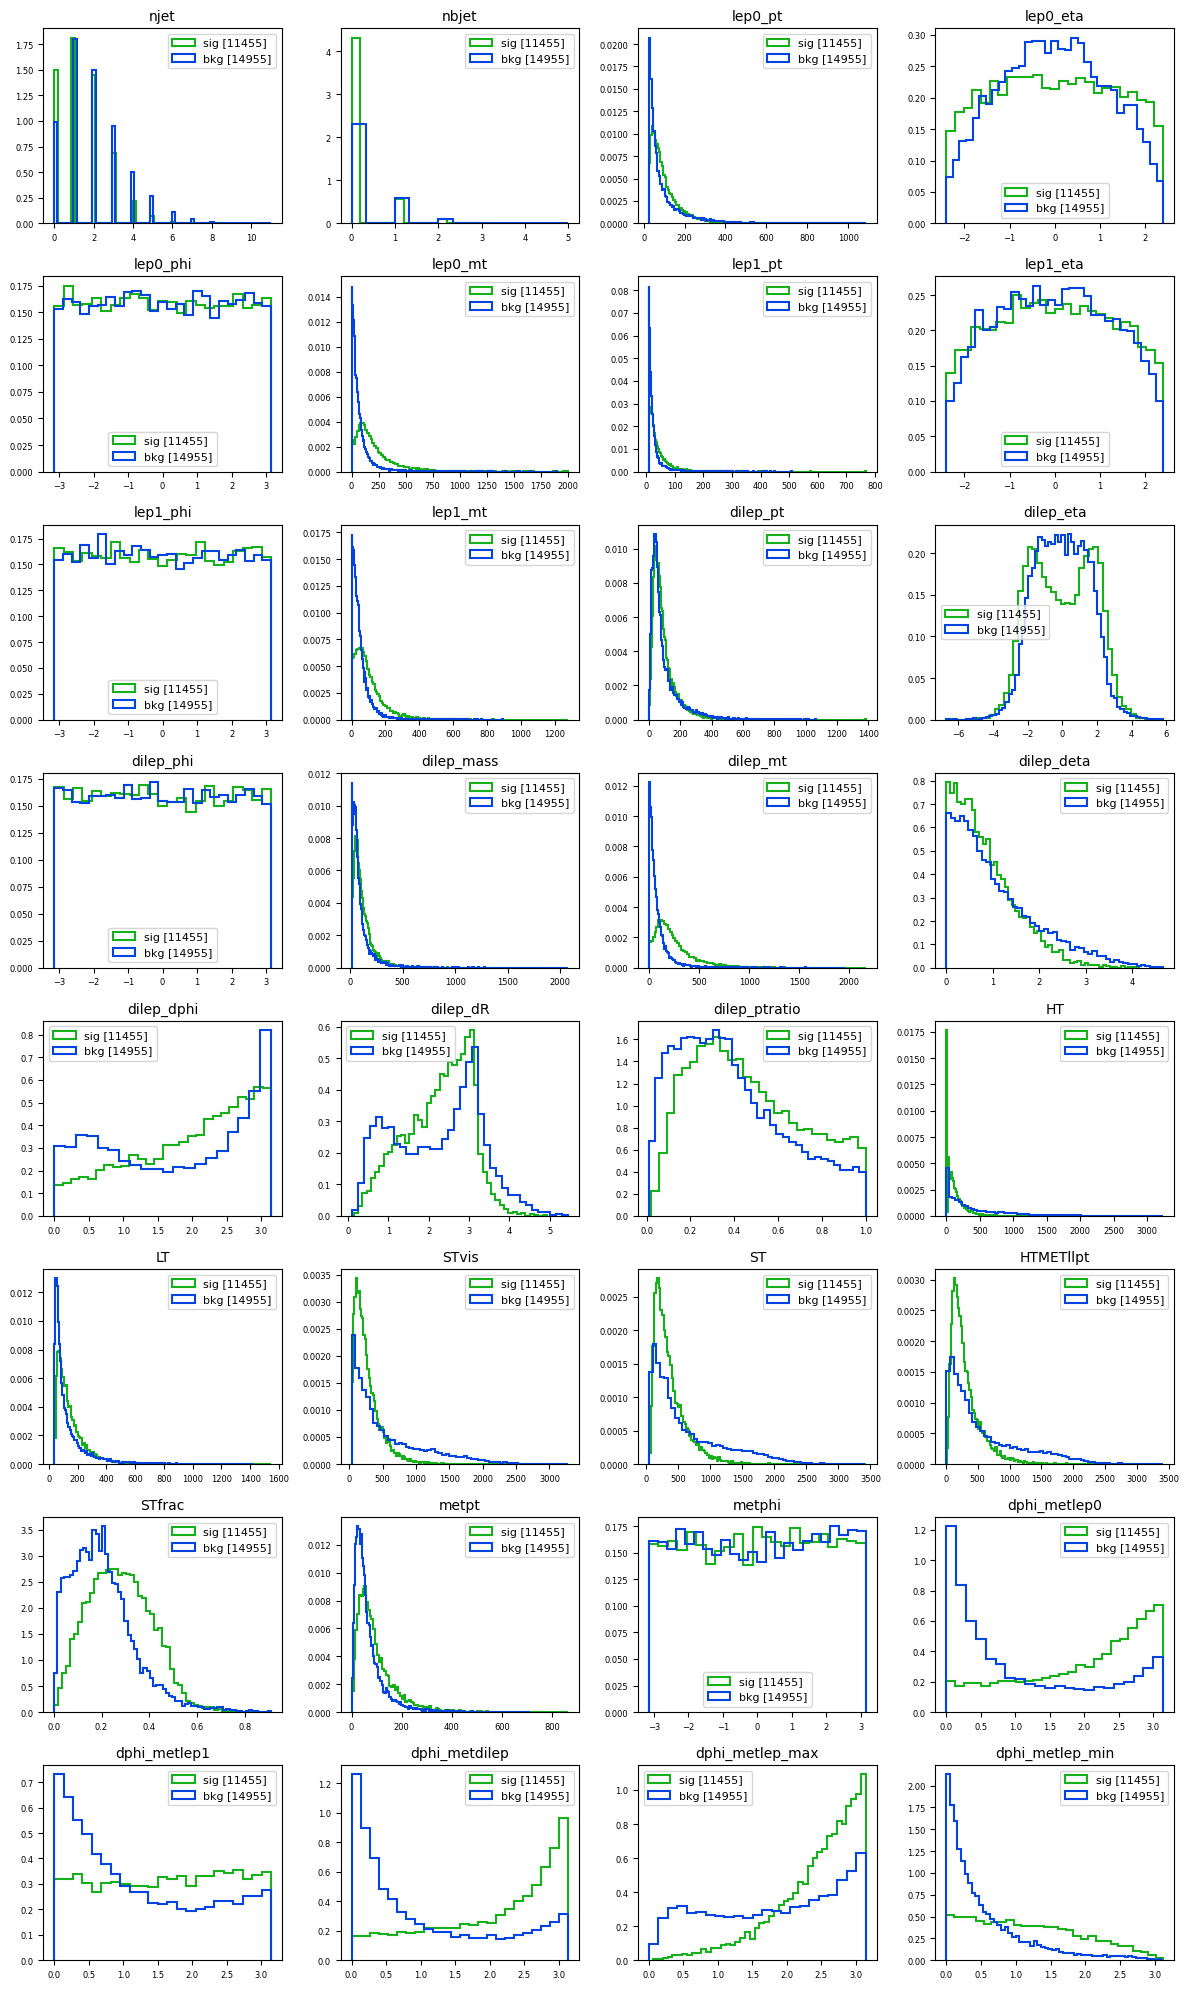

In [9]:
allvar = list(df.keys())

skipvar = ['channel', 'nlep', 'lep0_iso', 'lep0_sip3d', 'lep1_iso', 'lep1_sip3d',
           'jec', 'jer','wt_leptonSF', 'wt_trig', 'wt_bjet', 'weight', 'truth', 'sample', 'subsample']
plotvar = [var for var in allvar if var not in skipvar]

plot_in_group(plotvar, 'exploring_all_var')

### Deciding which variables to train on

The following input variables are chosen.
njet                $N_{\text{J}}$
dilep_mt            $M_{T}^{\text{  LL}}$
dilep_dR            $\Delta R(L_{0}, L_{1})$
dilep_dphi          $\Delta\phi(L_{0}, L_{1})$
HTMETllpt           $H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$
HT                  $H_{T}$
STfrac              $S_{T}^{\text{  frac}}$
dphi_metlep0        $\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$
dphi_metdilep       $\Delta\phi(LL, p_{T}^{\text{  miss}})$
dphi_metlep_max     $max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$
dphi_metlep_min     $min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$


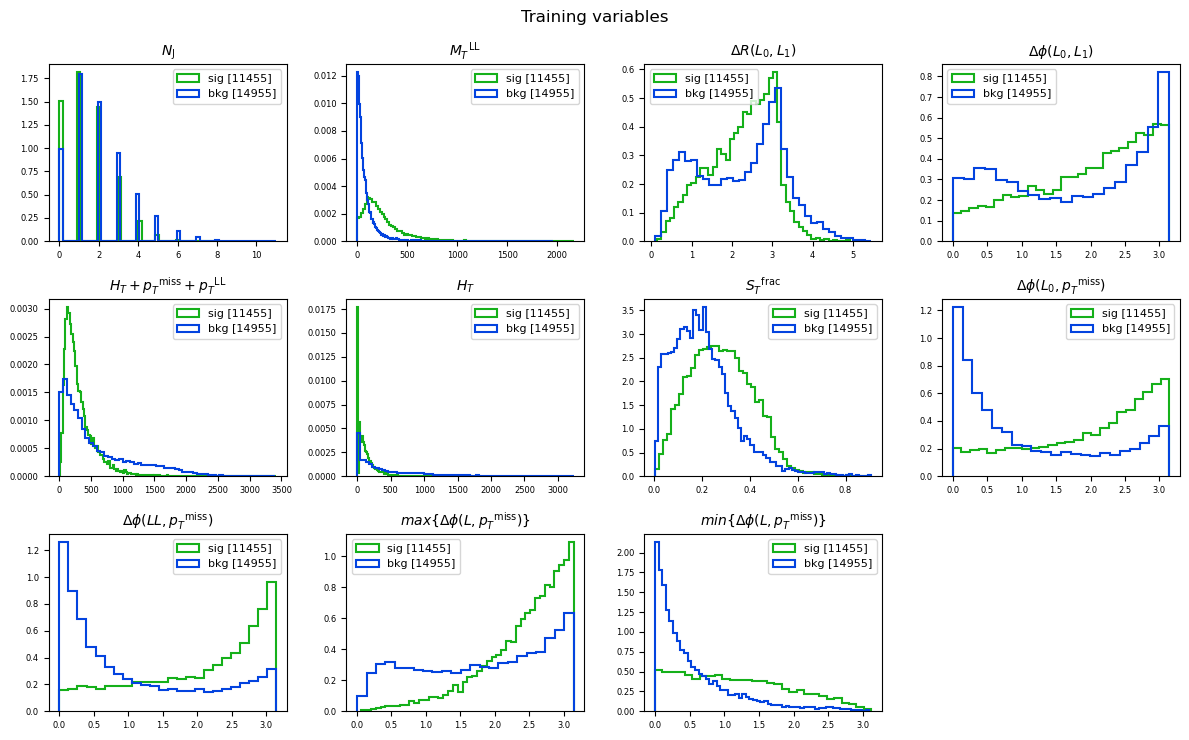

In [10]:
train_var = [
    'njet',
    'dilep_mt',
    'dilep_dR',
    'dilep_dphi',
    'HTMETllpt',
    'HT',
    'STfrac',
    'dphi_metlep0',
    'dphi_metdilep',
    'dphi_metlep_max',
    'dphi_metlep_min'
]

alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$'
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in train_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(train_var, 'training_varriables', suptitle='Training variables', alias=alias_)

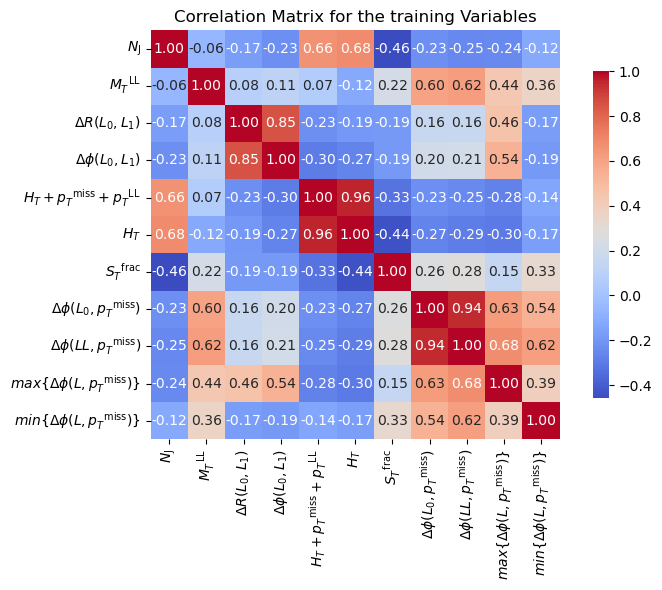

In [11]:
import seaborn as sns

correlation_data = df[train_var]
correlation_matrix = correlation_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))

#sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
#            cbar_kws={"shrink": .8}, ax=ax, xticklabels=train_var, yticklabels=train_var)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, ax=ax, 
            xticklabels=[latexname(var, alias_) for var in train_var],  # Use LaTeX aliases for x-axis labels
            yticklabels=[latexname(var, alias_) for var in train_var])  # Use LaTeX aliases for y-axis labels

ax.set_title('Correlation Matrix for the training Variables', fontsize=12)

plt.tight_layout()
plt.savefig('plots/correlation_trainvar.png', dpi=300, bbox_inches='tight')
plt.show()

## Preparing the Neural Network

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

2024-09-30 21:45:26.093889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training and testing dataset

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['truth'])

#Randomizing again:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

Statistics:
nSig split into train and test: 8018, 3437
nBkg split into train and test: 10469, 4486


### Min-max scaling

In [14]:
def FindMinMax(X, modelname):
    # Calculate min and max values
    maxval = X.max(axis=0)
    minval = X.min(axis=0)
    print('\n' + '-' * 25)
    print("Min Values found: ", minval)
    print("Max Values found: ", maxval)
    
    # Save min and max values to separate text files without headers
    np.savetxt(f'{modelname}/scaling_parameters_min.txt', minval, fmt='%.6f')
    np.savetxt(f'{modelname}/scaling_parameters_max.txt', maxval, fmt='%.6f')

def ApplyMinMax(X, min_filename, max_filename):
    # Load min values from the file
    minval = np.loadtxt(min_filename)
    
    # Load max values from the file
    maxval = np.loadtxt(max_filename)
    
    #print('Min from txt: ', minval)
    #print('Max from txt: ', maxval)
    
    # Calculate the difference
    diff = maxval - minval
    normed_X = X.copy()    
    # Scale the data only for non-constant columns
    nonconst = np.where(diff != 0)[0]
    normed_X[:, nonconst] = 2 * ((X[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    
    return normed_X

print('Functions for min-max scaling ready.')

Functions for min-max scaling ready.


In [15]:
#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

FindMinMax(X_train, modelname)

X_train = ApplyMinMax(X_train, f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')
X_test  = ApplyMinMax(X_test,  f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')


-------------------------
Min Values found:  [0.00000000e+00 0.00000000e+00 8.80549252e-02 0.00000000e+00
 6.95387793e+00 0.00000000e+00 2.38426728e-03 0.00000000e+00
 9.39369202e-05 4.97436523e-03 0.00000000e+00]
Max Values found:  [1.10000000e+01 2.00266919e+03 5.45770597e+00 3.14158392e+00
 3.41296289e+03 3.23524268e+03 9.08508956e-01 3.14111304e+00
 3.14149308e+00 3.14158392e+00 3.11893988e+00]


In [16]:
column_index = 1  # Replace 'i' with the column index you're interested in
print(np.min(X_train[:, column_index]), np.max(X_train[:, column_index]))

-1.0 1.0000000004525211


### Defining the model parameters

In [17]:
n_features = X_train.shape[1]
epochs_ = 25
batch_ = 300

model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_dim=n_features, name='FirstLayer'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', name='FinalLayer'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
print('The NN architecture is')
model.summary()


The NN architecture is
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FirstLayer (Dense)          (None, 64)                768       
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 FinalLayer (Dense)          (None, 1)                 17        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


2024-09-30 21:45:27.671379: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Training

In [18]:
%%time

history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
model.save(f'{modelname}/model_{modelname}.h5')
print('Training complete!\n')


Epoch 1/25
62/62 [==============================] - 1s 11ms/step - loss: 0.7357 - accuracy: 0.5396 - val_loss: 0.6210 - val_accuracy: 0.7060
Epoch 2/25
62/62 [==============================] - 1s 12ms/step - loss: 0.5424 - accuracy: 0.7404 - val_loss: 0.4885 - val_accuracy: 0.7525
Epoch 3/25
62/62 [==============================] - 0s 6ms/step - loss: 0.4681 - accuracy: 0.7730 - val_loss: 0.4456 - val_accuracy: 0.7838
Epoch 4/25
62/62 [==============================] - 1s 10ms/step - loss: 0.4346 - accuracy: 0.7962 - val_loss: 0.4216 - val_accuracy: 0.7988
Epoch 5/25
62/62 [==============================] - 0s 7ms/step - loss: 0.4119 - accuracy: 0.8092 - val_loss: 0.4005 - val_accuracy: 0.8100
Epoch 6/25
62/62 [==============================] - 1s 8ms/step - loss: 0.3971 - accuracy: 0.8164 - val_loss: 0.3908 - val_accuracy: 0.8208
Epoch 7/25
62/62 [==============================] - 0s 6ms/step - loss: 0.3866 - accuracy: 0.8205 - val_loss: 0.3813 - val_accuracy: 0.8210
Epoch 8/25
62/62 

In [19]:
info_filename = f'{modelname}/info_{modelname}.txt'

info = []
info.append(f'Model Name: {modelname}')
info.append(f'Signal and Background before filtering: {nsig}, {nbkg}')
info.append(f'Signal in training: {nsig_train}')
info.append(f'Signal in testing: {nsig_test}')
info.append(f'Background in training: {nbkg_train}')
info.append(f'Background in testing: {nbkg_test}')
info.append(f'Training Variables: {train_var}')
info.append(f'Number of Epochs: {epochs_}')
info.append(f'Batch Size: {batch_}')
info.append('\nModel Summary:\n')

model_summary = []
for layer in model.layers: model_summary.append(f'Layer: {layer.name}, Shape: {layer.output_shape}, Activation: {layer.activation.__name__}')
info.extend(model_summary)

# Write information to file
with open(info_filename, 'w') as f:
    for line in info:
        f.write(line + '\n')

print(f'Information saved to {info_filename}')

Information saved to qcd-vs-vlld-mu-m400-sept30/info_qcd-vs-vlld-mu-m400-sept30.txt


### Loss and accuracy

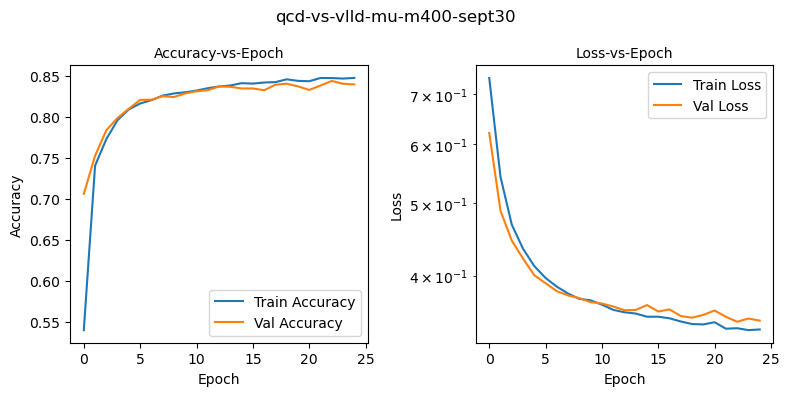

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/loss-and-accuracy.png')
plt.show()

### Using the trained model to predict

In [21]:
%%time

y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

print('Done!\n')

248/248 [==============================] - 1s 3ms/step
Done!

CPU times: user 11 s, sys: 12.5 s, total: 23.5 s
Wall time: 3.27 s


### Performance check

In [22]:
display(df_test)

,channel,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,lep0_mt,...,jec,jer,wt_leptonSF,wt_trig,wt_bjet,weight,truth,sample,subsample,score
0,0,2,2,1,94.002777,0.253967,-2.888672,0.359224,22.156250,6.248422,...,1.0,1.015614,0.983740,0.997546,0.958259,0.981326,0,QCD_MuEnriched,300to470,0.016986
1,1,2,0,0,76.973930,-1.382568,-1.397705,0.000000,0.489990,98.835327,...,1.0,1.000000,0.957311,0.997546,1.000000,0.954962,1,VLLD_mu,M100,0.822547
2,0,2,1,0,34.809540,-0.743774,-2.270508,0.139472,0.594238,4.947218,...,1.0,0.956662,0.980736,0.997546,1.000000,0.978329,0,QCD_MuEnriched,170to300,0.052743
3,2,2,2,0,38.499584,-0.029209,1.936523,0.019831,1.684570,88.018112,...,1.0,1.041761,0.946485,0.950463,0.877983,0.899599,1,VLLD_mu,M100,0.878724
4,2,2,2,0,81.659874,1.896729,-1.384766,0.000000,0.591309,118.176903,...,1.0,1.011967,0.971830,0.997680,0.857818,0.969575,1,VLLD_mu,M200,0.295965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7918,0,2,2,0,69.804794,-0.615112,-2.975586,0.018827,0.826660,120.364853,...,1.0,1.003563,0.987537,0.950463,0.778901,0.938618,1,VLLD_mu,M100,0.972260
7919,0,2,2,0,152.659775,-0.295471,0.295959,0.665814,1.708008,13.108532,...,1.0,1.005308,0.977790,0.950463,0.532707,0.929353,0,QCD_MuEnriched,470to600,0.015943
7920,2,2,0,0,90.612129,-0.809937,-1.388672,0.000000,1.361328,178.778488,...,1.0,1.000000,0.950130,0.997546,1.000000,0.947799,1,VLLD_mu,M100,0.891009
7921,0,2,2,0,44.316727,1.387939,-2.792969,0.041495,1.913086,74.545090,...,1.0,0.857483,0.956780,0.950463,0.879289,0.909384,1,VLLD_mu,M100,0.739808


In [23]:
%%capture

mybins = np.arange(0, 1.02, 0.02)
density_ = False

def extract_plot(df_, truth_, mybins, density_):
    scores_ = df_[df_['truth'] == truth_]['score']
    hist_ = plt.hist(scores_, bins=mybins, density=density_)
    counts_, bins_, _ = hist_
    errors_ = np.sqrt(counts_)
    integral_ = np.sum(counts_)
    scale_ = integral_ / len(scores_) if len(scores_) > 0 else 1
    weights_ = np.ones_like(scores_)
    if density_ == True: weights_ = np.ones_like(scores_) * (scale_ / len(scores_)) #Normalise integral to 1    
    return scores_, bins_, weights_, counts_, errors_

train_scores_sig, bins_sig_train, weights_sig_train, counts_sig_train, errors_sig_train = extract_plot(df_train, 1, mybins, density_)
train_scores_bkg, bins_bkg_train, weights_bkg_train, counts_bkg_train, errors_bkg_train = extract_plot(df_train, 0, mybins, density_)
test_scores_sig, bins_sig_test, weights_sig_test, counts_sig_test, errors_sig_test =      extract_plot(df_test,  1, mybins, density_)
test_scores_bkg, bins_bkg_test, weights_bkg_test, counts_bkg_test, errors_bkg_test =      extract_plot(df_test,  0, mybins, density_)

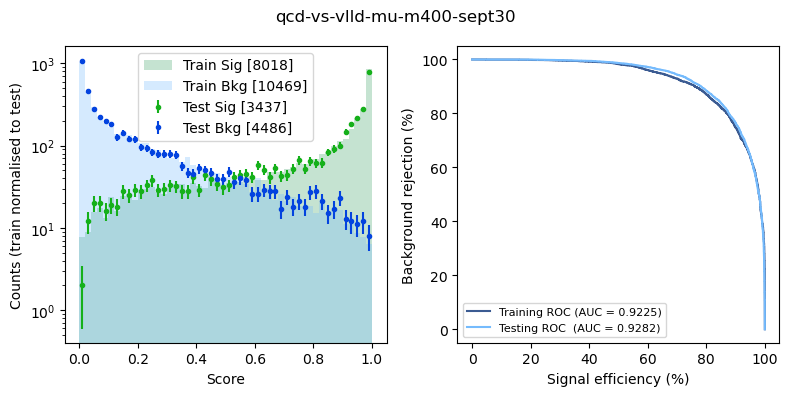

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density': density_,
    'log': False,
    'alpha':1.0
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

if density_:
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(test_scores_sig,  color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', **decorate_hist)
    ax[0].hist(test_scores_bkg,  color='xkcd:blue',  label=f'Test Bkg [{len(test_scores_bkg)}]',**decorate_hist)

else:
    # Calculate the scaling factors to normalize train histograms to match test integrals
    scale_factor_sig = np.sum(counts_sig_test) / np.sum(counts_sig_train) if np.sum(counts_sig_train) > 0 else 1
    scale_factor_bkg = np.sum(counts_bkg_test) / np.sum(counts_bkg_train) if np.sum(counts_bkg_train) > 0 else 1

    # Make train plots, normalized to match test histogram integrals
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_sig) * scale_factor_sig)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_bkg) * scale_factor_bkg)
    
    # Make test plots with error bars
    ax[0].errorbar(bins_sig_test[:-1] + np.diff(bins_sig_test) / 2, 
                   counts_sig_test, 
                   yerr=errors_sig_test, 
                   color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', 
                   fmt='o', markersize=3)
    
    ax[0].errorbar(bins_bkg_test[:-1] + np.diff(bins_bkg_test) / 2, 
                   counts_bkg_test, 
                   yerr=errors_bkg_test, 
                   color='xkcd:blue', label=f'Test Bkg [{len(test_scores_bkg)}]', 
                   fmt='o', markersize=3)

ax[0].set_xlabel('Score')
if density_:     ax[0].set_ylabel('Counts (normalized)')
if not density_: ax[0].set_ylabel('Counts (train normalised to test)')
ax[0].set_yscale('log')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/performance.png')
plt.show()

### Permutation importance of the training variables

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings
import io
from contextlib import redirect_stdout, redirect_stderr
warnings.filterwarnings("ignore")

# Define a scoring function compatible with permutation_importance
def keras_accuracy(model, X, y):
    # Get predictions
    y_pred = model.predict(X)
    if y_pred.shape[1] == 1:  # Binary classification case
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Threshold at 0.5
    else:  # Multi-class classification case
        y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y, y_pred_classes)

f = io.StringIO()
with redirect_stdout(f), redirect_stderr(f): # Suppressing evaluation output
    # Calculate permutation importance
    result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=30,
        random_state=42,
        n_jobs=-1,
        scoring=keras_accuracy
    )

2024-09-30 21:45:56.925153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 21:45:56.946889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 21:45:57.011665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30

248/248 [==============================] - 0s 898us/step


Sorted Features and Importance Scores:
HT                   0.271
dilep_mt             0.143
dphi_metlep_min      0.102
HTMETllpt            0.061
dphi_metlep_max      0.048
njet                 0.048
dilep_dR             0.042
dilep_dphi           0.033
dphi_metdilep        0.023
dphi_metlep0         0.012
STfrac               0.006


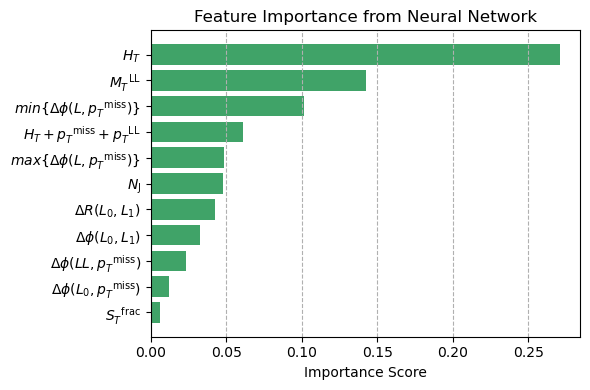

In [26]:
# Get feature importance scores and corresponding variable names
importance_scores = result.importances_mean
feature_names = train_var

# Sort importance scores and corresponding feature names
sorted_indices = np.argsort(importance_scores)[::-1]  # Indices for sorting from most to least
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]
# Apply LaTeX aliases to the sorted feature names
sorted_feature_names_latex = [latexname(name, alias_) for name in sorted_feature_names]

# Print the sorted features and importance scores
print("Sorted Features and Importance Scores:")
for name, score in zip(sorted_feature_names, sorted_importance_scores):
    print(f"{name:<20} {score:.3f}")

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(sorted_feature_names_latex, sorted_importance_scores, color='xkcd:greenish')  # Use LaTeX aliases
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
#ax.set_ylabel('Features')
ax.set_title('Feature Importance from Neural Network')
ax.grid(axis='x', linestyle='--')

# Save and show the plot
plt.tight_layout()
plt.savefig(f'{modelname}/feature_importance.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()
